In [1]:
import uproot as uproot

import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/ecal-experiment-1')

In [2]:
# %tensorboard --logdir=runs

In [3]:
root_file = uproot.open('data/0001_64k_real_spectra_15x15_spot.root')
nevents=None

# Наблюдаемые величины
RawE = root_file['ecalNT']['RawEnergyDeposit'].arrays(library='np')['RawEnergyDeposit'][:nevents]
x = root_file['ecalNT']['RawX'].arrays(library='np')['RawX'][:nevents]
y = root_file['ecalNT']['RawY'].arrays(library='np')['RawY'][:nevents]
z = root_file['ecalNT']['RawZ'].arrays(library='np')['RawZ'][:nevents]
EnergyDeposit = [img.reshape(15,15)[None,:,:] for img in np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])]

# Величины на входе симулятора
ParticlePDG = np.array(root_file['ecalNT']['ParticlePDG'].array())[:nevents]
ParticleMomentum_v = np.array(root_file['ecalNT']['ParticleMomentum'].array())[:nevents]
ParticleMomentum = np.sum(ParticleMomentum_v * ParticleMomentum_v, axis=1) ** 0.5

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [5]:
X = np.array(EnergyDeposit)
y = ParticleMomentum

# X = X[y < 10]
# y = y[y < 10]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_generator = torch.Generator()
train_generator.manual_seed(0)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=seed_worker, generator=train_generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

In [6]:
# torch.autograd.set_detect_anomaly(True)

In [7]:
class MyModel(nn.Module):
    def __init__(self, height=15, width=15) -> None:
        super(MyModel, self).__init__()

        self.height = height
        self.width = width

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
        )

        self.fc1 = nn.Linear(3600, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.flatten()
        return x

In [ ]:
def train_fn(train_loader, val_loader, model, optimizer, lr_scheduler, criterion, num_epochs, device, log_freq=None, max_grad_norm=20):

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    train_loss = []
    train_batch_idx = []
    train_num_batches = 0

    val_loss = []

    scaler = GradScaler()

    pbar = tqdm(range(1, num_epochs + 1))

    for epoch in pbar:
        epoch_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        num_batches = 0
        model.train()
        for data, trg in train_loader:
            train_num_batches += 1
            num_batches += 1
            optimizer.zero_grad()

            data = data.to(device)
            trg = trg.to(device)

            output = model(data)
            loss = criterion(output, trg, 1 / trg)

            epoch_loss += loss.detach()

            loss.backward()

            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            writer.add_scalar('Training loss', loss.item(), train_num_batches)
            writer.add_scalar('Model gradient norm', grad_norm.item(), train_num_batches)
            writer.add_scalar('Learning rate', get_lr(optimizer), train_num_batches)

            if log_freq is not None and train_num_batches % log_freq == 0:
                train_batch_idx.append(train_num_batches)
                train_loss.append(loss.item())
                clear_output(True)

                plt.figure(figsize=(15, 7))

                plt.subplot(1, 2, 1)
                plt.plot(train_batch_idx, train_loss)
                plt.xlabel("Batch index")
                plt.ylabel("RMSE / Momentum")
                plt.grid()
                plt.title("Train loss")

                plt.subplot(1, 2, 2)
                plt.plot(list(range(1, epoch)), val_loss)
                plt.xlabel("Epoch")
                plt.ylabel("RMSE / Momentum")
                plt.grid()
                plt.title("Validation loss")

                plt.show()
                print(f"Epoch: {epoch}/{num_epochs} || Batch: {num_batches}/{len(train_loader)} || Train loss: {epoch_loss / num_batches} || Val loss: {(val_loss[-1] if val_loss else -1.0):0.4f}")
        
        cur_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            for data, trg in val_loader:
                data = data.to(device)
                trg = trg.to(device)

                output = model(data)
                cur_loss += criterion(output, trg, 1 / trg).detach()
        
        cur_loss /= len(val_loader)

        val_loss.append(cur_loss.item())
        writer.add_scalar('Validation loss', cur_loss.item(), epoch)

        if lr_scheduler is not None:
            lr_scheduler.step()
    
    return train_loss, train_batch_idx

In [17]:
def loss_fn(pred, trg, weights, eps=1e-9, reduction='mean'):
    loss = torch.sqrt(F.mse_loss(pred, trg, reduction='none') + eps) * weights
    if reduction == 'mean':
        loss = loss.mean()
    return loss

def normal_loss_fn(pred, trg, weights):
    return F.mse_loss(pred, trg)

model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.5)
criterion = loss_fn
num_epochs = 20

train_loss, train_batch_idx = train_fn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    log_freq=None,
    max_grad_norm=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
def collect_losses(model, val_loader):
    trg_vals, loss_vals = [], []
    with torch.no_grad():
        for data, trg in val_loader:
            data = data.to(device)
            trg = trg.to(device)

            output = model(data)
            loss = loss_fn(output, trg, 1 / trg, reduction='none').detach()
            trg_vals += trg.cpu().numpy().tolist()
            loss_vals += loss.cpu().numpy().tolist()
    return trg_vals, loss_vals

val_trg, val_loss = collect_losses(model, val_loader)

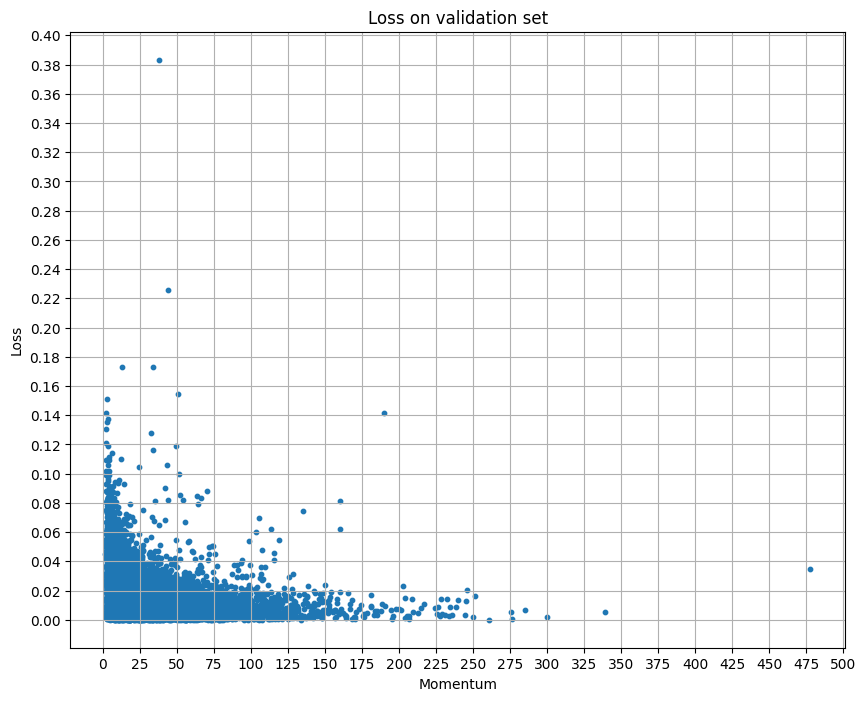

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(val_trg, val_loss, s=10)
plt.title('Loss on validation set')
plt.xlabel('Momentum')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()
plt.show()

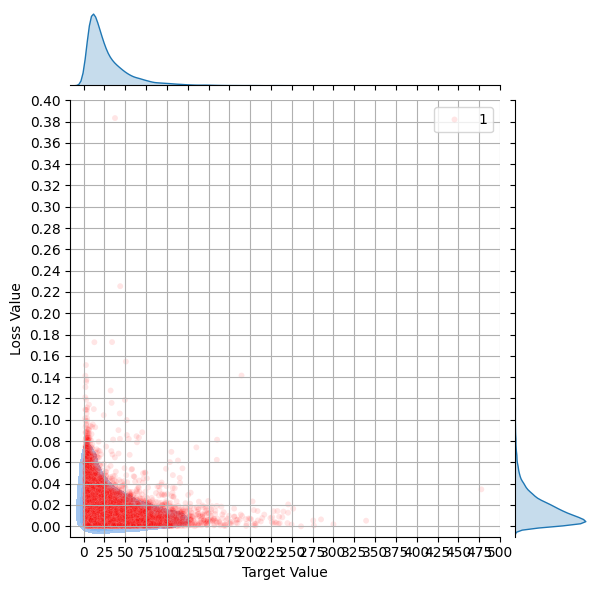

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.DataFrame({'Target Value': val_trg, 'Loss Value': val_loss})

sns.jointplot(data=data, x='Target Value', y='Loss Value', kind='kde', fill=True)

sns.scatterplot(data=data, x='Target Value', y='Loss Value', color='r', alpha=0.1, size=1)

plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()

plt.show()

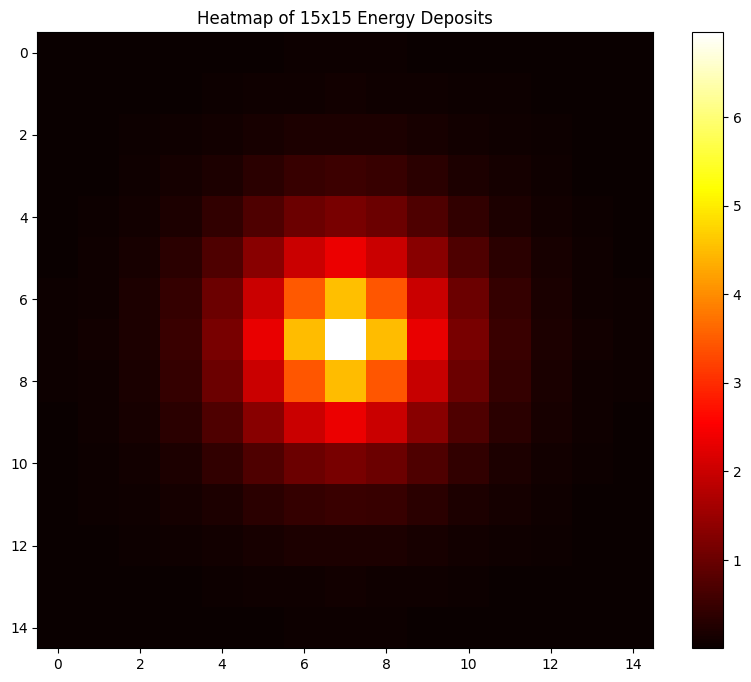

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(np.mean(np.log1p(X_train), axis=0).reshape(15, 15), cmap='hot', interpolation='nearest')
plt.title("Heatmap of 15x15 Energy Deposits")
plt.colorbar()
plt.show()

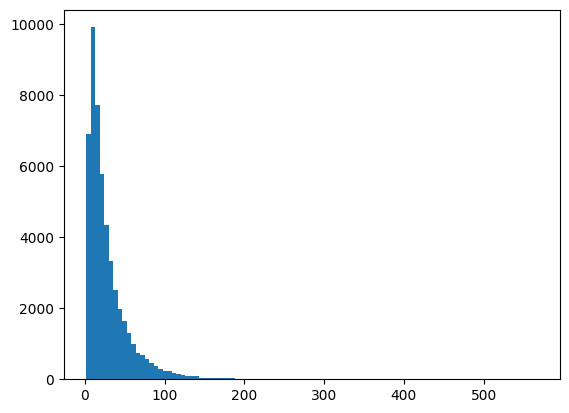

In [14]:
plt.hist(y_train, bins=100)

plt.show()